In [33]:
import pandas as pd
import numpy as np
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.layers import concatenate, Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample
from keras.callbacks import EarlyStopping
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from scipy import stats


['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

C:\Users\Sibasish Dhibar\AppData\Local\Temp\ipykernel_3532\1022165290.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


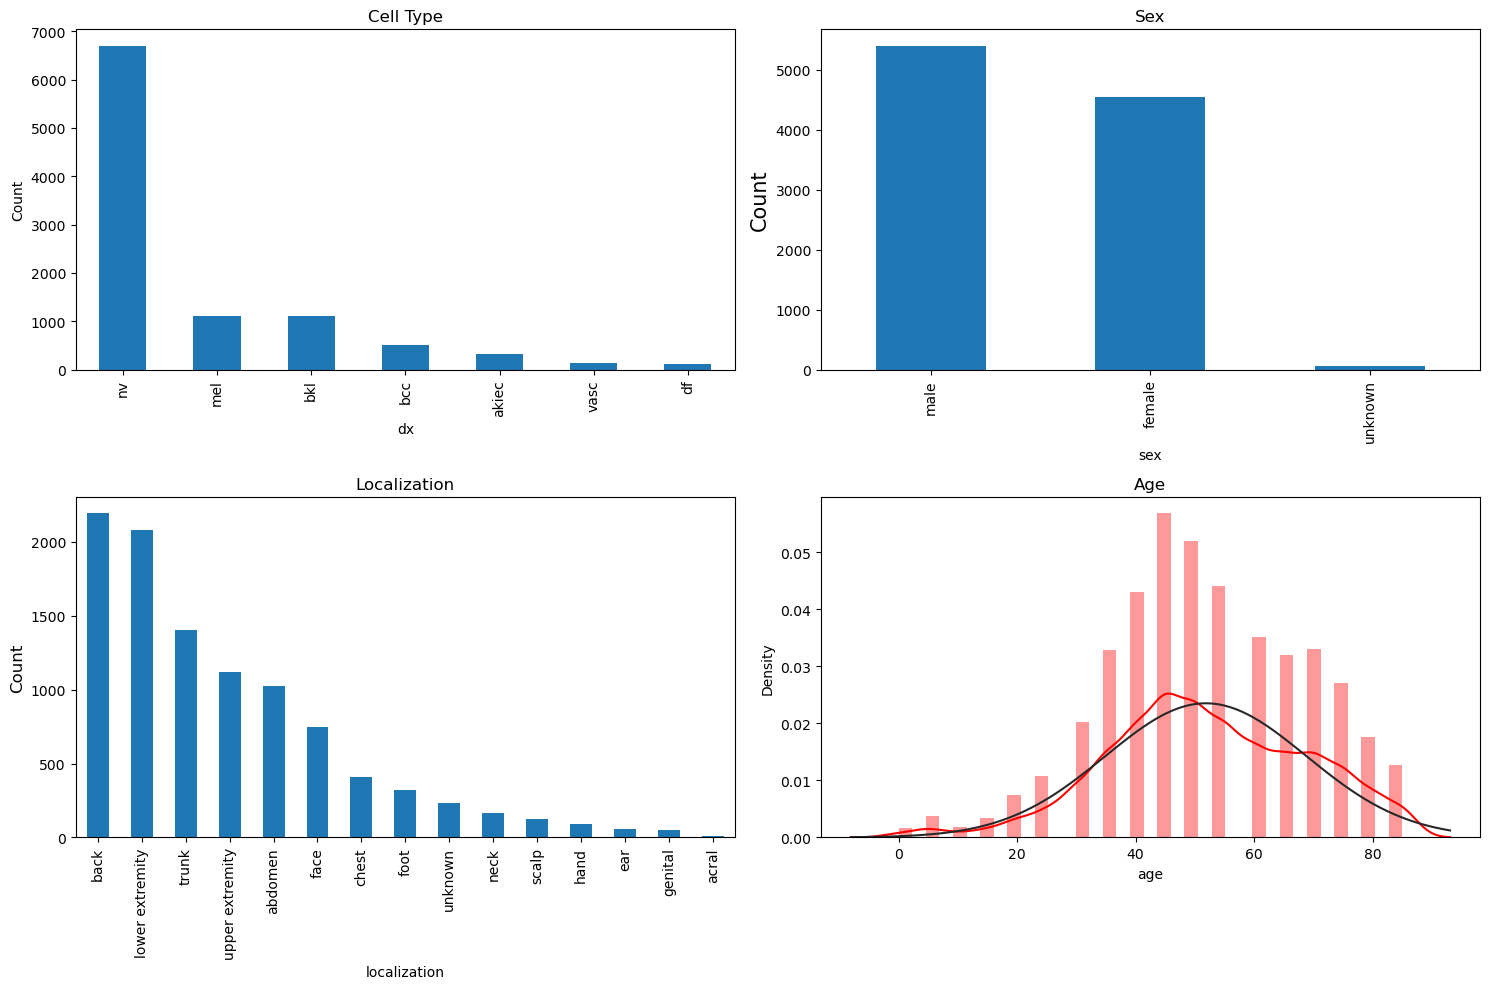

In [36]:

skin_df = pd.read_csv(r'C:\Users\Sibasish Dhibar\Desktop\Anomoly\Skin/HAM10000_metadata.csv')


SIZE=128

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [37]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=200 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


label
5    3352
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


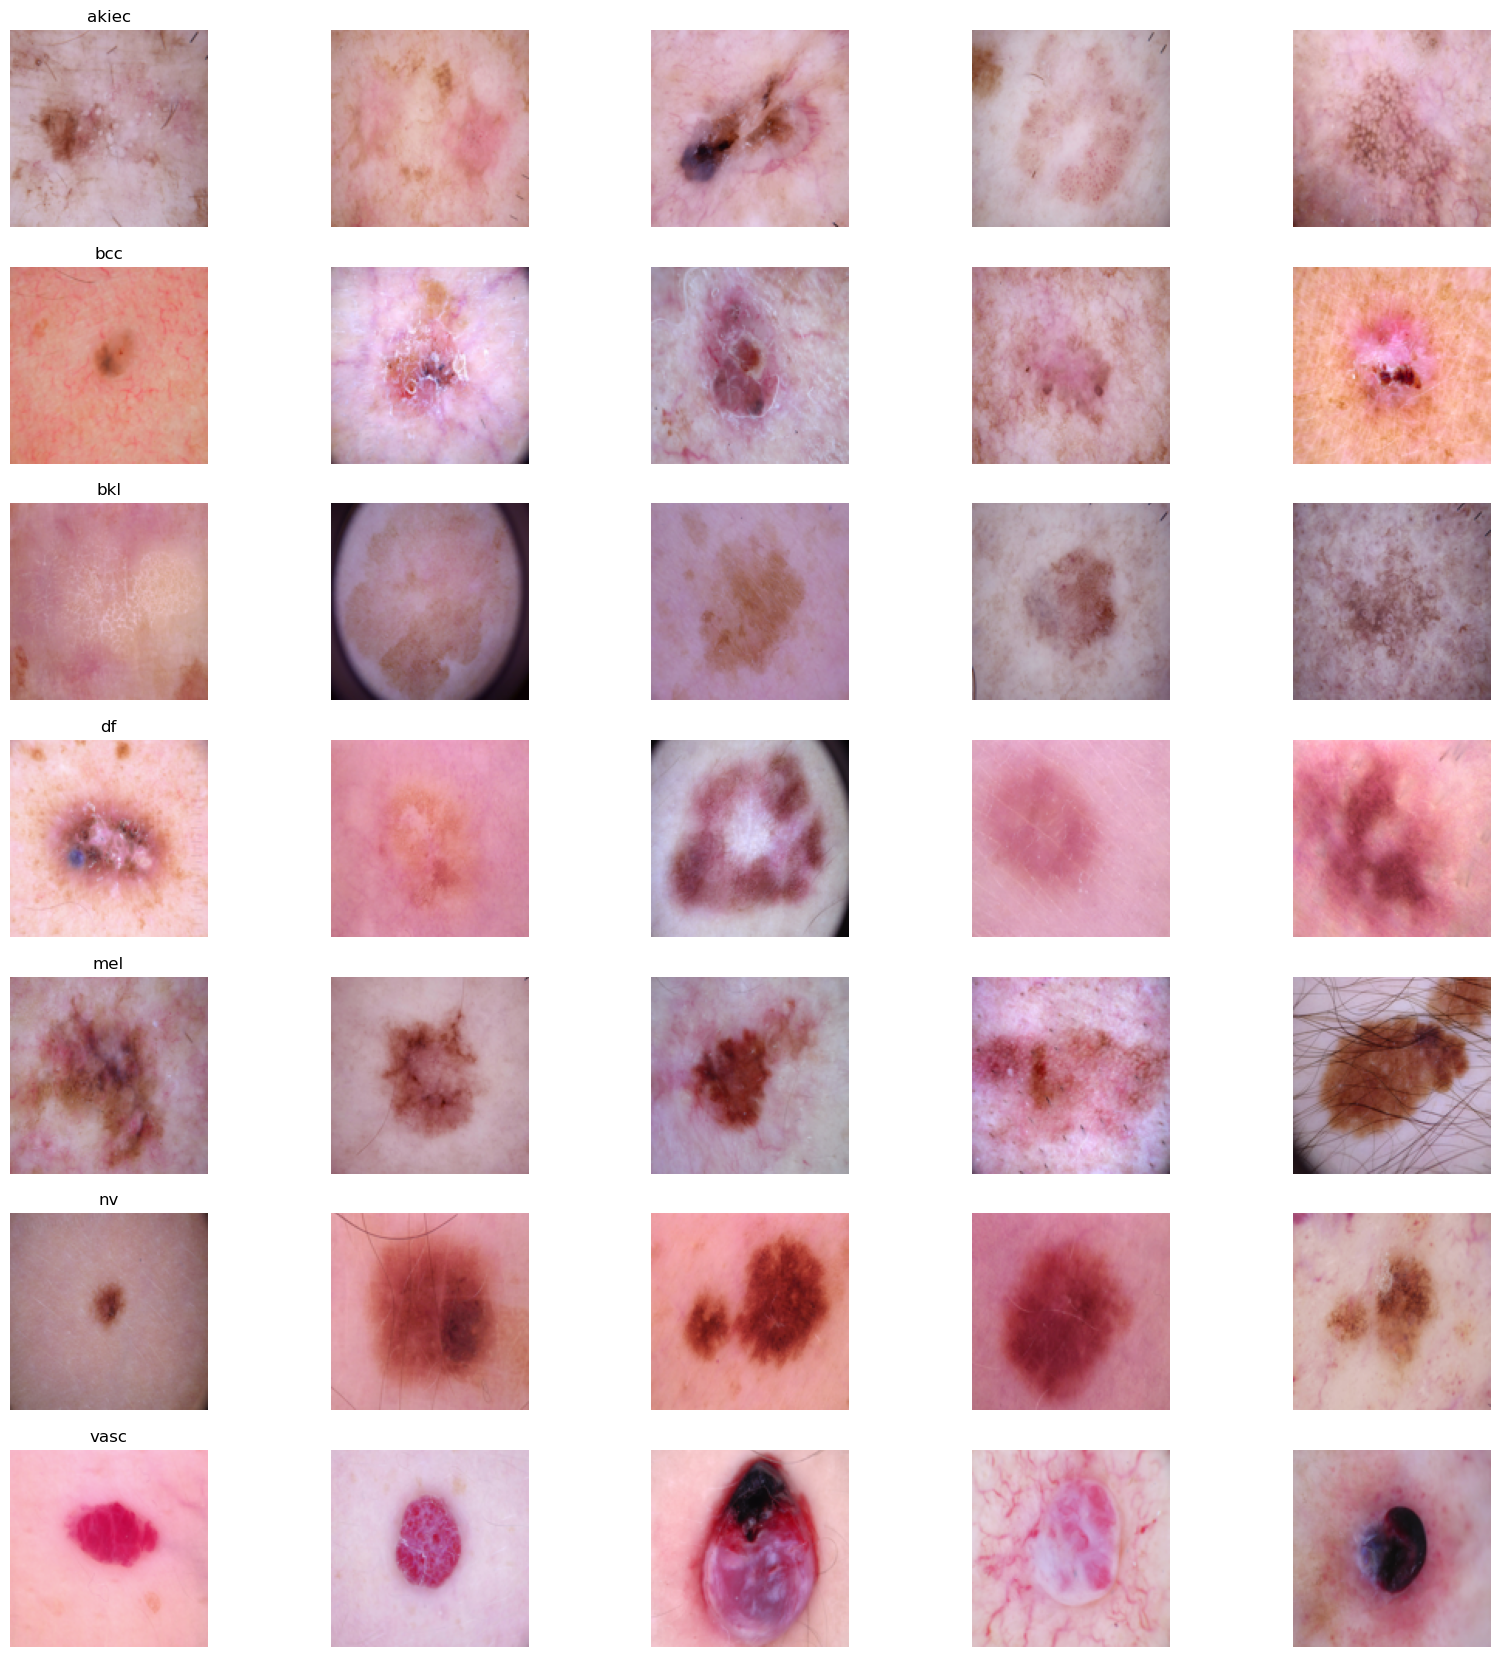

In [38]:
from seaborn import distplot
import seaborn as sns
from scipy import stats
import glob

max_samples = skin_df['label'].value_counts().max()
frac = 0.5  # Fraction of the max_samples to use for resampling

skin_df_balanced = pd.DataFrame()
for label in skin_df['label'].unique():
    df_label = skin_df[skin_df['label'] == label]
    n_samples = min(len(df_label), int(max_samples * frac))
    df_label_balanced = resample(df_label, replace=True, n_samples=n_samples, random_state=42)
    skin_df_balanced = pd.concat([skin_df_balanced, df_label_balanced])

# Rest of your code for reading and processing images

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob.glob(os.path.join(r'C:\Users\Sibasish Dhibar\Desktop\Anomoly\Skin/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing. Get a very small dataset for training as we will be 
# fitting it to many potential models. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_cat, test_size=0.20, random_state=42)

In [86]:
# Define the model with hyperparameters
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping

def get_model(input_shape, learning_rate, num_filters, filter_size, dropout_rate):
    input_tensor = Input(shape=input_shape)
    
    # Cast num_filters to int to ensure it's an integer value
    num_filters = int(num_filters)
    
# First Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Second Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)


    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output Layer
    output_tensor = Dense(7, activation='softmax')(x)  # Assuming 2 classes

    # Create and Compile Model
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])

    return model

In [ ]:
from pyswarms.single.global_best import GlobalBestPSO
from pyswarm import pso
# Define the objective function for PSO
def objective_function(hyperparameters_matrix):
    n_particles = hyperparameters_matrix.shape[0]
    cost = np.zeros(n_particles)

    for i in range(n_particles):
        hyperparameters = hyperparameters_matrix[i]
        learning_rate, num_filters, filter_size, dropout_rate = hyperparameters
        model = get_model((SIZE, SIZE, 3), learning_rate, int(num_filters), int(filter_size), dropout_rate)  # Example input shape
        model.fit(X_train, Y_train, epochs=30, batch_size=32, verbose=0)
        _, accuracy = model.evaluate(X_test, Y_test, verbose=0)
        cost[i] = -accuracy  # Negative accuracy for maximization
    
    return cost
# PSO hyperparameters
lb = [0.0001, 32, 2, 0.1]  # Lower bounds
ub = [0.01, 64, 5, 0.5]    # Upper bounds
options = {'c1': 2, 'c2': 2, 'w': 0.3}  # Cognitive and social components

optimizer = GlobalBestPSO(n_particles=5, dimensions=4, options=options, bounds=(lb, ub))

# Run PSO optimization multiple times and store results
results = []
for _ in range(5):
    best_cost, best_hyperparams = optimizer.optimize(objective_function, iters=10)
    results.append(best_hyperparams)

2024-01-30 16:00:29,602 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 2, 'c2': 2, 'w': 0.3}
pyswarms.single.global_best:  60%|██████    |6/10, best_cost=-.799

In [ ]:
# Assuming you want to use the hyperparameters from the last iteration
best_hyperparams_rounded = [results[-1][0], round(results[-1][1]), round(results[-1][2]), results[-1][3]]

In [ ]:
# Train the final model with optimized hyperparameters
final_model = get_model((SIZE, SIZE, 3), *best_hyperparams_rounded)
early_stopping = EarlyStopping(monitor='val_loss', patience=100)
print(final_model.summary())

In [ ]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print("Learning Rate:", best_hyperparams_rounded[0])
print("Number of Filters:", best_hyperparams_rounded[1])
print("Filter Size:", best_hyperparams_rounded[2])
print("Dropout Rate:", best_hyperparams_rounded[3])

In [ ]:
# Assuming x_train, y_train, x_test, and y_test are already prepared and available

# Correct the function name for model creation
model = get_model((128, 128, 3), 0.001, num_filters=64, filter_size=(3,3), dropout_rate=0.5)  # Adjusted for missing parameters
model.summary()

# Training the model
history = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, Y_test),
    verbose=2
)

# Evaluating the model on the test set
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])


In [95]:
# Evaluating the model on the test set
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.5206301808357239


In [ ]:
##combining
# Pseudocode for the hybrid optimization process
def hybrid_optimization(model_func, data, hyperparam_space):
    # Phase 1: PSO optimization
    pso_best_params = pso_optimize(model_func, data, hyperparam_space)
    
    # Phase 2: Refine with GWO starting from PSO's best solutions
    gwo_best_params = gwo_optimize(model_func, data, hyperparam_space, initial_pos=pso_best_params)
    
    return gwo_best_params

# Function to create and compile the model with given hyperparameters
def compile_model(hyperparams):
    model = get_model(input_shape=hyperparams['input_shape'], learning_rate=hyperparams['learning_rate'],
                      num_filters=hyperparams['num_filters'], filter_size=hyperparams['filter_size'],
                      dropout_rate=hyperparams['dropout_rate'])
    return model

# Example usage
best_hyperparams = hybrid_optimization(compile_model, data, hyperparam_space)
model = compile_model(best_hyperparams)
# Train the model with the best hyperparameters
